In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.porter import *
nltk.download('stopwords')
nltk.download('wordnet')

import re
import statistics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import skew

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\easha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\easha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
training_dataset = pd.read_csv('../../PrimaryDataset/mobile_preproccessed_whole_dataset.csv')

print('Dimensions of Dataset: ', training_dataset.shape)

Dimensions of Dataset:  (5320, 12)


In [3]:
#Replacing Blank Values with 'NaN' Values
training_dataset.replace("", np.nan, inplace = True)

#Droping Data which has 'Nan' value for 'Description' Column
training_dataset.dropna(subset = ['Description'], inplace = True)

#Checking of any 'NaN' values are present or not.
cond = (training_dataset['Description'] == np.nan)
print('NaN Values after Replacing: ',len(cond))

#Filtering data based on 'Duplicate_Bug_Ids' Column to get Duplicate Bugs
duplicate_test = training_dataset[training_dataset['Duplicate_Bug_Ids'] > 0]
print('Dimensions of Data with Duplicate Bug Ids: ', duplicate_test.shape)

NaN Values after Replacing:  5320
Dimensions of Data with Duplicate Bug Ids:  (562, 12)


In [4]:
#To Tokenize Data
ted = duplicate_test['Description']

tfidf = TfidfVectorizer()
stemmer = PorterStemmer()

def tokenizer(arg):
    tokens = re.split(r'(\W+)', arg.lower())
    tokens = [
        token for token in tokens
        if re.match('\\w+', token) and not re.match('\\d+', token)
    ]
    
    return list(map(stemmer.stem, tokens))

tfidf.tokenizer = tokenizer
tfidf_matrix_desc = tfidf.fit_transform(ted)

print('Dimensions of Data after Tokenization: ', tfidf_matrix_desc.shape)

Dimensions of Data after Tokenization:  (562, 3704)


In [5]:
#To calculate Cosine Similarity
tfidf_sim = TfidfVectorizer()

tfidf_matrix = tfidf_sim.fit_transform(ted)

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print('Cosine Similarity Matrix:')
print(cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.03626514 0.04771126 ... 0.00819527 0.00431848 0.00813439]
 [0.03626514 1.         0.0923619  ... 0.0118519  0.01097122 0.01176386]
 [0.04771126 0.0923619  1.         ... 0.02953536 0.02568051 0.03026084]
 ...
 [0.00819527 0.0118519  0.02953536 ... 1.         0.99182525 0.99854414]
 [0.00431848 0.01097122 0.02568051 ... 0.99182525 1.         0.99091449]
 [0.00813439 0.01176386 0.03026084 ... 0.99854414 0.99091449 1.        ]]
Cosine Similarity Matrix Dimensions:  (562, 562)


In [6]:
#To get Average Cosine Similarity Score
average = np.average(cosine_sim, axis=1)
average_df = pd.DataFrame(average, columns = ['Avg_Sim_Score'])

#To sort Data
average_for_sorting = average_df
sorted_average = average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(average))

#To get Median Of Distribution
median = statistics.median(average)
print('Median of Distribution: ', median)

Skewness of Distribution:  1.20656537160451
Median of Distribution:  0.05737684438117005


In [7]:
#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Score', value = average_df.values)

similar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= median]
dissimilar_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] < median]

print('Simlar Scores Dataset Dimensions: ', similar_score.shape)
print('Disimlar Scores Dataset Dimensions: ', dissimilar_score.shape)

#To get Average Similarity Scores 
scores = sorted_average['Avg_Sim_Score'].values.tolist()

Simlar Scores Dataset Dimensions:  (281, 13)
Disimlar Scores Dataset Dimensions:  (281, 13)


In [8]:
#To get data for BoxPlot

def get_box_plot_data(scores, title):
    scores_df = pd.DataFrame(scores)
    
    labels = ['Scores']
    plt.boxplot([scores], labels = labels)
    plt.ylabel('Cosine Similarity')
    plt.title(title)
    plt.show()
    
    scores_desc = {}
    scores_desc['lower_quartile'] = scores_df.describe().loc['25%']
    scores_desc['median'] = scores_df.describe().loc['50%']
    scores_desc['upper_quartile'] = scores_df.describe().loc['75%']
        
    return pd.DataFrame(scores_desc)

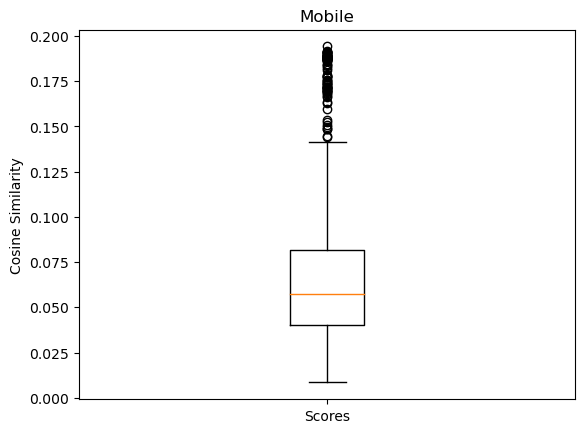

,lower_quartile,median,upper_quartile
0,0.040302,0.057377,0.08148


In [9]:
#To plot Box-Plot
result = get_box_plot_data(scores, 'Mobile')

#To get Description of Scores
result.head()

In [10]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_final_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs: ', similar_final_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs: ', dissimilar_final_score.shape)

Dimensions of Filtered Data with Similar Duplicate Bugs:  (141, 13)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs:  (141, 13)


# Unigram

In [11]:
#Unigram
unigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,1), lowercase=True, min_df=2)

unigram = unigram_vector.fit_transform(ted)

unigram_cosine_sim = cosine_similarity(unigram, unigram)

print('Cosine Similarity Matrix:')
print(unigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', unigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.04246202 0.05574089 ... 0.00927583 0.00489032 0.0092107 ]
 [0.04246202 1.         0.09862302 ... 0.01226055 0.01135518 0.01217447]
 [0.05574089 0.09862302 1.         ... 0.03048638 0.02652066 0.03124805]
 ...
 [0.00927583 0.01226055 0.03048638 ... 1.         0.99232143 0.99895438]
 [0.00489032 0.01135518 0.02652066 ... 0.99232143 1.         0.99181753]
 [0.0092107  0.01217447 0.03124805 ... 0.99895438 0.99181753 1.        ]]
Cosine Similarity Matrix Dimensions:  (562, 562)


In [12]:
#To get Average Unigram Cosine Similarity Score
unigram_average = np.average(unigram_cosine_sim, axis=1)
unigram_average_df = pd.DataFrame(unigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
unigram_average_for_sorting = pd.DataFrame(unigram_average_df)
sorted_unigram_average = unigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(unigram_average))

#To get Median Of Distribution
unigram_median = statistics.median(unigram_average)
print('Median of Distribution: ', unigram_median)

#To get Unigram Scores
unigram_scores = sorted_unigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  1.0962665741732966
Median of Distribution:  0.06785992311407305


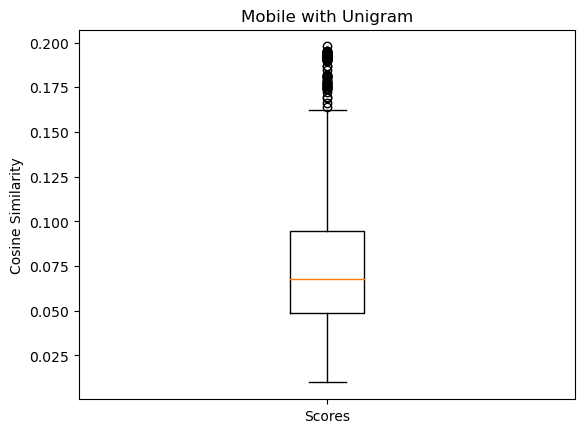

,lower_quartile,median,upper_quartile
0,0.048793,0.06786,0.094407


In [13]:
#To plot Box-Plot
result = get_box_plot_data(unigram_scores, 'Mobile with Unigram')

#To get Description of Unigram Scores
result.head()

In [14]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To Filter data for Similar Bugs
similar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_unigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Score'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram: ', similar_unigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram: ', dissimilar_unigram_score.shape)

#Download to csv
# similar_unigram_score.to_csv("Mobile_textually_similar_unigram_final.csv",index=False)
# dissimilar_unigram_score.to_csv("Mobile_textually_dissimilar_unigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Unigram:  (122, 13)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Unigram:  (199, 13)


# Bigram

In [15]:
#Bigram
bigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,2), lowercase=True, min_df=2)

bigram = bigram_vector.fit_transform(ted)

bigram_cosine_sim = cosine_similarity(bigram, bigram)

print('Cosine Similarity Matrix:')
print(bigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', bigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02522813 0.0310252  ... 0.00533419 0.00277215 0.00530103]
 [0.02522813 1.         0.05589652 ... 0.00717946 0.00655449 0.00713482]
 [0.0310252  0.05589652 1.         ... 0.01672415 0.0143412  0.01715586]
 ...
 [0.00533419 0.00717946 0.01672415 ... 1.         0.99121391 0.99886273]
 [0.00277215 0.00655449 0.0143412  ... 0.99121391 1.         0.99042036]
 [0.00530103 0.00713482 0.01715586 ... 0.99886273 0.99042036 1.        ]]
Cosine Similarity Matrix Dimensions:  (562, 562)


In [16]:
#To get Average Bigram Cosine Similarity Score
bigram_average = np.average(bigram_cosine_sim, axis=1)
bigram_average_df = pd.DataFrame(bigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
bigram_average_for_sorting = bigram_average_df
sorted_bigram_average = bigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(bigram_average))

#To get Median Of Distribution
bigram_median = statistics.median(bigram_average)
print('Median of Distribution: ', bigram_median)

#To get Bigram Scores
bigram_scores = sorted_bigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  1.373813151215287
Median of Distribution:  0.0451110828595558


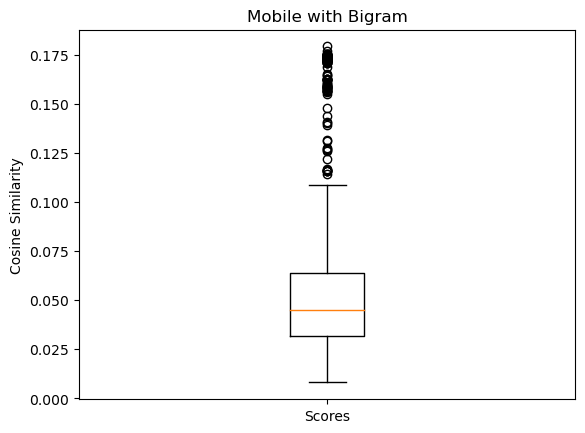

,lower_quartile,median,upper_quartile
0,0.031624,0.045111,0.063928


In [17]:
#To plot Box-Plot
result = get_box_plot_data(bigram_scores, 'Mobile with Bigram')

#To get Description of Unigram Scores
result.head()

In [18]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Bigram', value = bigram_average_df.values)

#To Filter data for Similar Bugs
similar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_bigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Bigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram: ', similar_bigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram: ', dissimilar_bigram_score.shape)

#Download to csv
# similar_bigram_score.to_csv("Mobile_textually_similar_bigram_final.csv",index=False)
# dissimilar_bigram_score.to_csv("Mobile_textually_dissimilar_bigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Bigram:  (141, 14)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Bigram:  (141, 14)


# Trigram

In [19]:
#Trigram
trigram_vector = TfidfVectorizer(analyzer='word', ngram_range=(1,3), lowercase=True, min_df=2)

trigram = trigram_vector.fit_transform(ted)

trigram_cosine_sim = cosine_similarity(trigram, trigram)

print('Cosine Similarity Matrix:')
print(trigram_cosine_sim)
print('Cosine Similarity Matrix Dimensions: ', trigram_cosine_sim.shape)

Cosine Similarity Matrix:
[[1.         0.02361163 0.02642169 ... 0.00460778 0.0023603  0.00458376]
 [0.02361163 1.         0.04669972 ... 0.00608413 0.00547486 0.00605241]
 [0.02642169 0.04669972 1.         ... 0.01289602 0.01089995 0.01324227]
 ...
 [0.00460778 0.00608413 0.01289602 ... 1.         0.98972238 0.9986182 ]
 [0.0023603  0.00547486 0.01089995 ... 0.98972238 1.         0.98873356]
 [0.00458376 0.00605241 0.01324227 ... 0.9986182  0.98873356 1.        ]]
Cosine Similarity Matrix Dimensions:  (562, 562)


In [20]:
#To get Average Of Distribution
trigram_average = np.average(trigram_cosine_sim, axis=1)
trigram_average_df = pd.DataFrame(trigram_average, columns = ['Avg_Sim_Score'])

#To sort Data
trigram_average_for_sorting = trigram_average_df
sorted_trigram_average = trigram_average_for_sorting.sort_values(by = 'Avg_Sim_Score', ascending = False)

#To get Skewness Of Distribution
print('Skewness of Distribution: ', skew(trigram_average))

#To get Median Of Distribution
trigram_median = statistics.median(trigram_average)
print('Median of Distribution: ', trigram_median)

#To get Trigram Scores
trigram_scores = sorted_trigram_average['Avg_Sim_Score'].values.tolist()

Skewness of Distribution:  1.4730488219169071
Median of Distribution:  0.040260184440509286


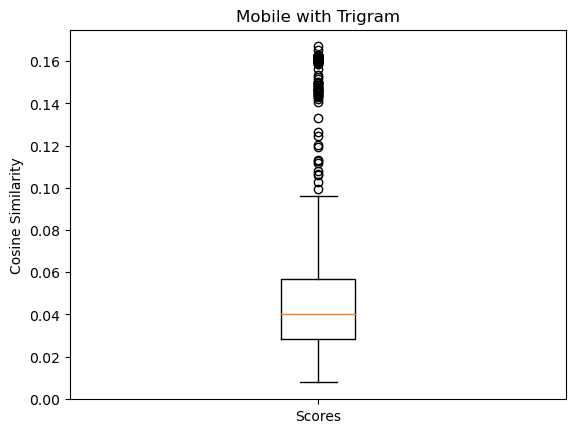

,lower_quartile,median,upper_quartile
0,0.028266,0.04026,0.056586


In [21]:
#To plot Box-Plot
result = get_box_plot_data(trigram_scores, 'Mobile with Trigram')

#To get Description of Unigram Scores
result.head()

In [22]:
#Lower and Upper Limit
lower_limit = result.iloc[0][0]
upper_limit = result.iloc[0][2]

#To add Column in DataFrame
duplicate_test.insert(loc = 7, column = 'Average_Cos_Similarity_Trigram', value = trigram_average_df.values)

#To Filter data for Similar Bugs
similar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] >= upper_limit]

#To Filter data for Dissimilar Bugs
dissimilar_trigram_score = duplicate_test[duplicate_test['Average_Cos_Similarity_Trigram'] <= lower_limit]

print('Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram: ', similar_trigram_score.shape)
print('Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram: ', dissimilar_trigram_score.shape)

#Download to csv
# similar_trigram_score.to_csv("Mobile_textually_similar_trigram_final.csv",index=False)
# dissimilar_trigram_score.to_csv("Mobile_textually_dissimilar_trigram_final.csv",index=False)

Dimensions of Filtered Data with Similar Duplicate Bugs using Trigram:  (141, 15)
Dimensions of Filtered Data with Dissimilar Duplicate Bugs using Trigram:  (141, 15)


# Comparing Unigram and Bigram

In [23]:
#Comparing Similar Unigram and Bigram
print('Is Similar Unigram and Bigram Data Same?: ', similar_bigram_score['Bug ID'].equals(similar_unigram_score['Bug ID']))

#To convert Data in List
unigram_bug_list = list(similar_unigram_score['Bug ID'])
bigram_bug_list = list(similar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Similar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id = []
for i,v in enumerate(bigram_bug_list):
    if (v in unigram_bug_list):
        count_id +=1
        dup_id_in_bug_id.append(v)
        
print('Duplicate Bug IDs in Similar Unigram and Bigram Data: ', len(dup_id_in_bug_id))

#To get Similar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_sim = similar_bigram_score[similar_bigram_score['Bug ID'].isin(dup_id_in_bug_id)]

print('Dimensions of new Data: ', new_sim.shape)

Is Similar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Unigram and Bigram Data:  122
Dimensions of new Data:  (122, 14)


In [24]:
#Comparing Dis-similar Unigram and Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', dissimilar_bigram_score['Bug ID'].equals(dissimilar_unigram_score['Bug ID']))

#To convert Data in List
unigram_dis_bug_list = list(dissimilar_unigram_score['Bug ID'])
bigram_dis_bug_list = list(dissimilar_bigram_score['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Unigram and Bigram Data
count_id = 0
dup_id_in_bug_id_dis = []
for i,v in enumerate(bigram_dis_bug_list):
    if (v in unigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis.append(v)
        
print('Duplicate Bug IDs in Dissimilar Unigram and Bigram Data: ', len(dup_id_in_bug_id_dis))

#To get Dissimilar Bigram Data present from Duplicate Bug IDs in Unigram and Bigram List 
new_dissim = dissimilar_bigram_score[dissimilar_bigram_score['Bug ID'].isin(dup_id_in_bug_id_dis)]

print('Dimensions of new Data: ', new_dissim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Unigram and Bigram Data:  138
Dimensions of new Data:  (138, 14)


# Comparing Trigram and Unigram-Bigram

In [25]:
#Comparing Similar Trigram and Unigram-Bigram
print('Is Disimilar Unigram and Bigram Data Same?: ', similar_trigram_score['Bug ID'].equals(new_sim['Bug ID']))

#To convert Data in List
trigram_bug_list = list(similar_trigram_score['Bug ID'])
unigram_bigram_bug_list = list(new_sim['Bug ID'])

#To get Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_tri = []
for i,v in enumerate(trigram_bug_list):
    if (v in unigram_bigram_bug_list):
        count_id +=1
        dup_id_in_bug_id_tri.append(v)
        
print('Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_tri))

#To get Similar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_sim = similar_trigram_score[similar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_tri)]

print('Dimensions of new Data: ', final_new_sim.shape)

Is Disimilar Unigram and Bigram Data Same?:  False
Duplicate Bug IDs in Similar Trigram and Unigram-Bigram Data:  122
Dimensions of new Data:  (122, 15)


In [26]:
#Comparing Dissimilar Trigram and Unigram-Bigram
print('Is Disimilar Trigram and Unigram-Bigram Data Same?: ', dissimilar_trigram_score['Bug ID'].equals(new_dissim['Bug ID']))

#To convert Data in List
trigram_dis_bug_list = list(dissimilar_trigram_score['Bug ID'])
unigram_bigram_dis_bug_list = list(new_dissim['Bug ID'])

#To get Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data
count_id = 0
dup_id_in_bug_id_dis_tri = []
for i,v in enumerate(trigram_dis_bug_list):
    if (v in unigram_bigram_dis_bug_list):
        count_id +=1
        dup_id_in_bug_id_dis_tri.append(v)
        
print('Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data: ', len(dup_id_in_bug_id_dis_tri))

#To get Dissimilar Trigram Data present from Duplicate Bug IDs in Trigram and Unigram-Bigram List 
final_new_dissim = dissimilar_trigram_score [dissimilar_trigram_score['Bug ID'].isin(dup_id_in_bug_id_dis_tri)]

print('Dimensions of new Data: ', final_new_dissim.shape)

#Download to csv
#final_new_sim.to_csv("Mobile_final_sim.csv",index=False)
#final_new_dissim.to_csv("Mobile_final_dis.csv",index=False)

Is Disimilar Trigram and Unigram-Bigram Data Same?:  False
Duplicate Bug IDs in Dissimilar Trigram and Unigram-Bigram Data:  131
Dimensions of new Data:  (131, 15)


# Textually Similar

In [27]:
#To Drop Duplicates
df_sim = final_new_sim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_sim.shape)

# Duplicate Pair ( b- & b+)
sim = df_sim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
sim.reset_index(drop=True, inplace=True)
na = sim.to_numpy()

def createData(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_sim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]].copy()
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
sim['Summary1'] = createData('Bug ID', 'Summary', 0)
sim['Description1'] = createData('Bug ID', 'Description', 0)
sim['Summary2'] = createData('Bug ID', 'Summary', 1)
sim['Description2'] = createData('Bug ID', 'Description', 1)
sim['is_similar'] = 1

#To show Data
sim.head()

Dimensions of Data After Dropping Duplicates:  (122, 15)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,1536820,1535913.0,0.124524,['Intermittent org.mozilla.geckoview.test.WebE...,[' markdown filed by nerli at mozilla co...,[],[],1
1,1466482,1464351.0,0.162806,['Intermittent org.mozilla.geckoview.test.Geck...,['filed by apavel at mozilla com job id...,['Intermittent org.mozilla.geckoview.test.Geck...,['filed by ncsoregi at mozilla com job ...,1
2,1677708,1678895.0,0.162700,['Intermittent org.mozilla.geckoview.test.PanZ...,[' filed by malexandru at mozilla com ...,[],[],1
3,1703350,1681261.0,0.099396,['Intermittent org.mozilla.geckoview.test.Text...,[' filed by csabou at mozilla com pars...,[],[],1
4,1574141,1564920.0,0.094800,['Intermittent org.mozilla.geckoview.test.Cont...,[' filed by cbrindusan at mozilla com ...,[],[],1


In [28]:
#To Create a Copy
df_sim_fin = sim.copy()

#To Replace '[]' with '0' 
df_sim_fin['Summary2'] = df_sim_fin['Summary2'].replace(['[]'],'0')
df_sim_fin['Description2'] = df_sim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_sim_fin.drop(df_sim_fin.loc[df_sim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_sim_fin.shape)

Dimensions of Data after Cleaning:  (50, 8)


# Textually Dissimilar

In [29]:
#To Drop Duplicate
df_dissim = final_new_dissim.drop_duplicates(subset = ['Bug ID', 'Summary','Description','Average_Cos_Similarity_Score', 'Average_Cos_Similarity_Bigram', 'Average_Cos_Similarity_Trigram','Duplicate_Bug_Ids' ], keep='first')

print('Dimensions of Data After Dropping Duplicates: ', df_dissim.shape)

# Duplicate Pair ( b- & b+)
dissim = df_dissim[['Bug ID', 'Duplicate_Bug_Ids', 'Average_Cos_Similarity_Trigram']]
dissim.reset_index(drop=True, inplace=True)
na = dissim.to_numpy()

def createDataForDissimilarity(training_column, tem_column, col_index):
    s = []
    for i in range(0,df_dissim.shape[0]):
        tem = training_dataset.loc[training_dataset[training_column] == na[i, col_index]]
        s.append(str(tem[tem_column].values))
    se = pd.Series(s)
    return se.values

#To add Data in Columns
dissim['Summary1'] = createDataForDissimilarity('Bug ID', 'Summary', 0)
dissim['Description1'] = createDataForDissimilarity('Bug ID', 'Description', 0)
dissim['Summary2'] = createDataForDissimilarity('Bug ID', 'Summary', 1)
dissim['Description2'] = createDataForDissimilarity('Bug ID', 'Description', 1)
dissim['is_similar'] = 1

#To show Data
dissim.head()

Dimensions of Data After Dropping Duplicates:  (131, 15)


,Bug ID,Duplicate_Bug_Ids,Average_Cos_Similarity_Trigram,Summary1,Description1,Summary2,Description2,is_similar
0,1655196,1644486.0,0.022843,['High ratio of ERROR_NO_MINIDUMP_HEADER'],['talking to gsvelto today he pointed out tha...,[],[],1
1,1482876,1482487.0,0.007713,"['Storage crash: lastInsertedRowID, 32-bit onl...",['the brief crash report thread name thre...,['Crash in Storage:ConcreteSQLiteDBConnection....,['this crash is happening in firefox for ios ...,1
2,1331985,1355440.0,0.026783,['Crash: [UIApplication _cachedSystemAnimation...,['created attachment crash ...,['Crash in UIApplication#_cachedSystemAnimatio...,['created attachment crash ...,1
3,1494388,1460411.0,0.024667,['Remaining mochitest and reftest failures in ...,[' jobs repo try tier revision demo...,[],[],1
4,1568667,1568295.0,0.022837,['Extend ContentBlocking API to support Social...,['stp is a new blocklist setting we need to su...,['Expose Disconnect social tracker list (socia...,['fenix would like to expose a user setting to...,1


In [30]:
#To Create a Copy
df_dissim_fin= dissim.copy()

#To Replace '[]' with '0' 
df_dissim_fin['Summary2'] = df_dissim_fin['Summary2'].replace(['[]'],'0')
df_dissim_fin['Description2'] = df_dissim_fin['Description2'].replace(['[]'],'0')

#To Drop rows with '0' value in 'Summary2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Summary2']=='0'].index, inplace=True)

#To Drop rows with '0' value in 'Description2' Column
df_dissim_fin.drop(df_dissim_fin.loc[df_dissim_fin['Description2']=='0'].index, inplace=True)

print('Dimensions of Data after Cleaning: ', df_dissim_fin.shape)

Dimensions of Data after Cleaning:  (89, 8)


In [31]:
#To Download Final Processed Data
df_sim_fin.to_csv("../../PreProcessedData/Mobile_textually_similar_pair.csv")
df_sim_fin.to_csv("../../PreProcessedData/Mobile_textually_dissimilar_pair.csv")